### ———《Dual Custom Convolutional Neural Networks of Ensemble learning with Attention Mechanism》———

In [1]:
# Import necessary libraries
import os
import cv2
import seaborn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Input, optimizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, \
     precision_recall_curve

In [2]:
def get_datasets(root="data/gender"):
    label_names = ["male", "female"]
    datasets, labels = [], []
    for name in os.listdir(root):
        dir_path = root + "/" + name
        for label_name in os.listdir(dir_path):
            img_dir_path = dir_path + "/" + label_name
            for img_name in os.listdir(img_dir_path):
                img_path = img_dir_path + "/" + img_name
                label = label_names.index(label_name)
                datasets.append(img_path)
                labels.append(label)
                
# --------------------------------- Task2: Data Split: 70% train & 15% test & 15 validation --------------------------------

    datasets_train, datasets_test_val, labels_train, labels_test_val = train_test_split(datasets, labels,
                                                                                        train_size=0.7, shuffle=True)
    datasets_test, datasets_val, labels_test, labels_val = train_test_split(datasets_test_val, labels_test_val,
                                                                                        train_size=0.5, shuffle=True)
    
    # Write the file path and label information into a text file, so that I can use these files to load and process data later.   
    with open("datasets/train.txt", "w", encoding="utf-8") as f:
        for i in range(len(labels_train)):
            f.write(datasets_train[i] + "\t" + str(labels_train[i]) + "\n")
    with open("datasets/test.txt", "w", encoding="utf-8") as f:
        for i in range(len(labels_test)):
            f.write(datasets_test[i] + "\t" + str(labels_test[i]) + "\n")
    with open("datasets/val.txt", "w", encoding="utf-8") as f:
        for i in range(len(labels_val)):
            f.write(datasets_val[i] + "\t" + str(labels_val[i]) + "\n")

In [3]:
# Create a data generator for batch processing data.
class DataGenerator(Sequence):

    def __init__(self, root, batch_size):
        super(DataGenerator, self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.datasets, self.labels = self.get_datasets()

    def __getitem__(self, item):
        batch_x = self.datasets[item * self.batch_size:(item + 1) * self.batch_size]
        batch_y = self.labels[item * self.batch_size:(item + 1) * self.batch_size]

        return np.concatenate([np.expand_dims(self.transform(img_path), axis=0) for img_path in batch_x],
                              axis=0), self.one_hot(batch_y)

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def get_datasets(self):
        datasets, labels = [], []
        with open(self.root, "r", encoding="utf-8") as f:
            for line in f.readlines():
                line_split = line.strip().split("\t")
                datasets.append(line_split[0])
                labels.append(int(line_split[-1]))

        return datasets, labels

# ------------------------ Task1: Data Preprocessing(implementation of resizing, normalization, augmentation) ------------------------
    @staticmethod
    def transform(img_path):
        image = Image.open(img_path)
        preprocess = transforms.Compose([
            # resizing
            transforms.Resize(112),
            
            # augmentation 
            transforms.RandomRotation(15),  # Random rotation
            transforms.CenterCrop(112),  # Cutting center 112 pixels
            transforms.ToTensor(),  # Convert to Tensor type
            
            # normalization
            transforms.Normalize(  
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])
        image = preprocess(image).permute(1, 2, 0)
        # print(image.shape)
        return image

    @staticmethod
    def one_hot(y):
        y_ = np.zeros((len(y), 2), dtype=int)
        for i in range(len(y)):
            y_[i, int(y[i])] = 1

        return y_
    
    # This function achieves random rotation of a given image.
    def random_rotate(image, max_angle):
        angle = np.random.uniform(-max_angle, max_angle)
        height, width = image.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
        return rotated_image

    # This function realizes random cropping of a given image.
    def random_crop(image, crop_size):

        height, width = image.shape[:2]
        crop_height, crop_width = crop_size
        if crop_width >= width or crop_height >= height:
            raise ValueError("Crop size should be smaller than image size")
        x = np.random.randint(0, width - crop_width + 1)
        y = np.random.randint(0, height - crop_height + 1)
        cropped_image = image[y:y + crop_height, x:x + crop_width]
        return cropped_image

In [4]:
# Define a function named channel_attention, which implements a channel attention mechanism.
def channel_attention1(inputs, ratio=0.25):
    channel = inputs.shape[-1]
    x_max = layers.GlobalMaxPooling2D()(inputs)
    x_avg = layers.GlobalAveragePooling2D()(inputs)
    x_max = layers.Reshape([1, 1, -1])(x_max)
    x_avg = layers.Reshape([1, 1, -1])(x_avg)
    x_max = layers.Dense(channel * ratio)(x_max)
    x_avg = layers.Dense(channel * ratio)(x_avg)
    x_max = layers.Activation('relu')(x_max)
    x_avg = layers.Activation('relu')(x_avg)
    x_max = layers.Dense(channel)(x_max)
    x_avg = layers.Dense(channel)(x_avg)
    x = layers.Add()([x_max, x_avg])
    x = tf.nn.sigmoid(x)
    x = layers.Multiply()([inputs, x])

    return x

# Define a function named spatial_attention, which implements a spatial attention mechanism.
def spatial_attention(inputs):
    x_max = tf.reduce_max(inputs, axis=3, keepdims=True)
    x_avg = tf.reduce_mean(inputs, axis=3, keepdims=True)
    x = layers.concatenate([x_max, x_avg])
    x = layers.Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = tf.nn.sigmoid(x)
    x = layers.Multiply()([inputs, x])

    return x

# -----------------------------------Task 3: Custom CNN Model 1 Construction with Attention Mechanism -----------------------------------
def CBAM_attention(inputs):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1a')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1b')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)
    # 2nd block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2a')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2b')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    x = channel_attention1(x)
    x = spatial_attention(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(rate=0.1)(x)
    x = layers.Dense(2, activation="softmax")(x)
    return x
    # Combine the channel and spatial attention mechanism named CBAM attention and add it to the custom Model 1.

def get_model1():
    inputs = Input(shape=[112, 112, 3])
    outputs = CBAM_attention(inputs)
    model = Model(inputs, outputs)
    return model

In [5]:
# Define a function named se_block, which implements a se_block attention mechanism.
def se_block(inputs, ratio=4):
    in_channel = inputs.shape[-1]
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Reshape(target_shape=(1, 1, in_channel))(x)
    x = layers.Dense(in_channel // ratio)(x)
    x = tf.nn.relu(x)
    x = layers.Dense(in_channel)(x)
    x = tf.nn.sigmoid(x)
    outputs = layers.multiply([inputs, x])

    return outputs

# -----------------------------------Task 3: Custom CNN Model 2 Construction with Attention Mechanism-----------------------------------
def senet(inputs):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1a')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1b')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2a')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2b')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    x = se_block(x)  # position attention

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(rate=0.1)(x)  # Dropout layer
    x = layers.Dense(2, activation="softmax")(x)

    return x


def get_model2():
    inputs = Input(shape=[112, 112, 3])
    outputs = senet(inputs)
    model = Model(inputs, outputs)

    return model

In [6]:
# Defined a custom loss function
class CrossEntropyLoss(Loss):

    def __init__(self, name='custom_cross_entropy_loss'):
        super(CrossEntropyLoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred))
        return loss

In [7]:
# Defined a custom accuracy function
class Accuracy(object):

    def __call__(self, y_true, y_pred, *args, **kwargs):
        accuracy = np.mean(y_true == y_pred)
        return accuracy

In [8]:
# -------------Task 4: Model Training: Using learning rate, batch size and the number of epochs, dropout as hyper-parameters-------------
def train(model_name):
    if model_name == "model1":
        model = get_model1()
    elif model_name == "model2":
        model = get_model2()
    else:
        raise KeyError("model name must be model1 or model2")
    model.compile()
    train_loader = DataGenerator(root="datasets/train.txt", batch_size=32) # batch size
    val_loader = DataGenerator(root="datasets/val.txt", batch_size=32)
    
    # Call the custom loss and accuracy functions
    loss_func = CrossEntropyLoss()
    accuracy_func = Accuracy()
    
    optimizer = optimizers.Adadelta(learning_rate=0.1) # learning rate
    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    best_loss = 10000
    for epoch in range(50): # epochs
        train_acc, train_loss = train_one_epoch(model, train_loader, optimizer, loss_func, accuracy_func, epoch)
        val_acc, val_loss = get_val_result(model, val_loader, loss_func, accuracy_func)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        print(f"epoch:{epoch + 1},train_acc:{train_acc},train_loss:{train_loss},val_acc:{val_acc},val_loss:{val_loss}")
        if (epoch + 1) % 5 == 0:
            model.save(f"models/{model_name}_epoch{epoch + 1}.h5")
        if train_loss < best_loss:
            best_loss = train_loss
            model.save(f"models/{model_name}_best.h5")

    plt.figure(figsize=(8, 8))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.savefig(f"plots/{model_name}_loss-epoch.jpg")

    plt.figure(figsize=(8, 8))
    plt.plot(train_accs, label="train_acc")
    plt.plot(val_accs, label="val_acc")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.savefig(f"plots/{model_name}_accuracy-epoch.jpg")

In [9]:
# Define a function train_one_epoch, which is used to train an epoch of model.
def train_one_epoch(model, train_loader, optimizer, loss_func, accuracy_func, epoch):
    labels_pred, labels_true, losses = np.array([]), np.array([]), []
    data = tqdm(train_loader) # Iterate the train_loader with tqdm to provide a progress bar.
    for batch, (x, y) in enumerate(data):
        labels_true = np.concatenate([labels_true, np.argmax(y, axis=-1)], axis=-1)
        with tf.GradientTape() as tape:
            y_pred = model(x)
            labels_pred = np.concatenate([labels_pred, np.argmax(y_pred.numpy(), axis=-1)], axis=-1)
            loss = loss_func(y, y_pred)
            losses.append(float(loss))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        data.set_description_str(f"epoch:{epoch + 1},batch:{batch + 1},loss:{float(loss)}")

    accuracy = accuracy_func(labels_true, labels_pred)

    return float(accuracy), float(np.mean(losses))

In [10]:
# This function is used to evaluate the performance of the model on the validation dataset.
def get_val_result(model, val_loader, loss_func, accuracy_func):
    data = tqdm(val_loader)
    labels_pred, labels_true, losses = np.array([]), np.array([]), []
    for x, y in data:
        labels_true = np.concatenate([labels_true, np.argmax(y, axis=-1)], axis=-1)
        y_pred = model(x)
        labels_pred = np.concatenate([labels_pred, np.argmax(y_pred.numpy(), axis=-1)], axis=-1)
        loss = loss_func(y, y_pred)
        losses.append(float(loss))

    accuracy = accuracy_func(labels_true, labels_pred)

    return float(accuracy), float(np.mean(losses))

In [11]:
# -------------------------------------------  Task 5: Model Testing and Evaluation  ------------------------------------------- 
def get_test_result(model_path):
    model = load_model(model_path)
    test_loader = DataGenerator(root="datasets/test.txt", batch_size=32)
    labels_onehot, labels_prob = [], []
    for x, y in test_loader:
        labels_onehot.append(y)
        prob = model.predict(x)
        labels_prob.append(prob)
    labels_onehot = np.concatenate(labels_onehot, axis=0)
    labels_prob = np.concatenate(labels_prob, axis=0)
    labels_pred = np.argmax(labels_prob, axis=-1)
    labels_true = np.argmax(labels_onehot, axis=-1)

    
# Calculate and record the evaluation metrics 
# loss, accuracy, ROC-AUC curve, recall, precision, sensitivity, specificity, confusion matrix, and f1-score, and precision-recall curve.
    accuracy = accuracy_score(labels_true, labels_pred)
    error = 1 - accuracy
    recall = recall_score(labels_true, labels_pred)
    precision = precision_score(labels_true, labels_pred)
    f1 = f1_score(labels_true, labels_pred)
    matrix = confusion_matrix(labels_true, labels_pred)
    TP, FP, FN, TN = matrix[0, 0], matrix[0, 1], matrix[1, 0], matrix[1, 1]
    TPR = TP / (TP + FN)
    TNR = TN / (FP + TN)
    print(
        f"accuracy:{accuracy},error:{error},recall:{recall},precision:{precision},f1:{f1},sensitivity:{TPR},specificity:{TNR}")

    matrix = pd.DataFrame(matrix, columns=["male", "female"], index=["male", "female"])
    plt.figure(figsize=(5, 5))
    seaborn.heatmap(matrix, cmap="GnBu", annot=True)
    plt.savefig(f"plots/{model_path.split('/')[-1].split('.')[0]}_confusion_matrix.jpg")

    plt.figure(figsize=(10, 10))
    fpr, tpr, _ = roc_curve(labels_true, labels_prob[:, -1])
    plt.plot([0, 1], [0, 1], "r--")
    plt.plot(fpr, tpr, c="green", label=f"AUC:{auc(fpr, tpr):.3f}")
    plt.legend()
    plt.title("roc-curve")
    plt.savefig(f"plots/{model_path.split('/')[-1].split('.')[0]}_roc_curve.jpg")

    plt.figure(figsize=(10, 10))
    precision, recall, thresholds = precision_recall_curve(labels_true, labels_prob[:, -1])
    plt.plot(recall, precision, c="green")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("precision-recall-curve")
    plt.savefig(f"plots/{model_path.split('/')[-1].split('.')[0]}_precision_recall_curve.jpg")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.32it/s]
D:\Softwares\anaconda\envs\JustOnce\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch:1,train_acc:0.5989717223650386,train_loss:0.6618088615495105,val_acc:0.625,val_loss:0.6338132964937311


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.31it/s]


epoch:2,train_acc:0.7043701799485861,train_loss:0.5875434161618699,val_acc:0.7226027397260274,val_loss:0.5672962132253145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.31it/s]


epoch:3,train_acc:0.7693720161586486,train_loss:0.5325480110423509,val_acc:0.7328767123287672,val_loss:0.569788330479672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.30it/s]


epoch:4,train_acc:0.8079324274697025,train_loss:0.49232618614684703,val_acc:0.583904109589041,val_loss:0.7133179683434335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:5,train_acc:0.8145427836944547,train_loss:0.4886602035095525,val_acc:0.8613013698630136,val_loss:0.4583213941047066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.31it/s]


epoch:6,train_acc:0.8431876606683805,train_loss:0.4632022457067357,val_acc:0.636986301369863,val_loss:0.6454571799228066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.30it/s]


epoch:7,train_acc:0.8523687109805361,train_loss:0.4540602984123452,val_acc:0.7568493150684932,val_loss:0.5417964474151009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.30it/s]


epoch:8,train_acc:0.8611825192802056,train_loss:0.4440983031378236,val_acc:0.8664383561643836,val_loss:0.4408531957551053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.30it/s]


epoch:9,train_acc:0.8751377157546824,train_loss:0.43384271929430407,val_acc:0.7054794520547946,val_loss:0.5967464776415574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:10,train_acc:0.8846860080793243,train_loss:0.42463051856950274,val_acc:0.8202054794520548,val_loss:0.4912077031637493


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:11,train_acc:0.879544619904517,train_loss:0.42808841861957725,val_acc:0.8801369863013698,val_loss:0.43894399153558833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:12,train_acc:0.8828497980168931,train_loss:0.42439084586709047,val_acc:0.7106164383561644,val_loss:0.5926208151014227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:13,train_acc:0.8810135879544619,train_loss:0.4261822939612145,val_acc:0.8715753424657534,val_loss:0.44376374075287267


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:14,train_acc:0.8946015424164524,train_loss:0.4171574129614719,val_acc:0.8595890410958904,val_loss:0.45377026576744883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:15,train_acc:0.8905618802791039,train_loss:0.41703533398550613,val_acc:0.875,val_loss:0.4433923755821429


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:16,train_acc:0.8986412045538009,train_loss:0.4113565080387648,val_acc:0.8664383561643836,val_loss:0.44454087238562734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:17,train_acc:0.8946015424164524,train_loss:0.41346240944640583,val_acc:0.8698630136986302,val_loss:0.4470782938756441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:18,train_acc:0.9052515607785531,train_loss:0.4065603236126345,val_acc:0.8681506849315068,val_loss:0.442752458547291


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:19,train_acc:0.8949687844289387,train_loss:0.4103297459524731,val_acc:0.8732876712328768,val_loss:0.4366122390094556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:20,train_acc:0.9074550128534704,train_loss:0.4032881890618524,val_acc:0.8784246575342466,val_loss:0.43330819669522735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:21,train_acc:0.9048843187660668,train_loss:0.4066522973914479,val_acc:0.8595890410958904,val_loss:0.447962866017693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:22,train_acc:0.9074550128534704,train_loss:0.40145852884580924,val_acc:0.8835616438356164,val_loss:0.42976878191295426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:23,train_acc:0.9103929489533603,train_loss:0.39890965715397236,val_acc:0.8732876712328768,val_loss:0.4419246425754146


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:24,train_acc:0.9151670951156813,train_loss:0.3954911651306374,val_acc:0.9041095890410958,val_loss:0.4127614200115204


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:25,train_acc:0.9133308850532501,train_loss:0.39622266937133876,val_acc:0.886986301369863,val_loss:0.42785657393304927


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:26,train_acc:0.9159015791406537,train_loss:0.3945273455492286,val_acc:0.8955479452054794,val_loss:0.4230103633905712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:27,train_acc:0.9272860815277267,train_loss:0.38533925906170247,val_acc:0.8972602739726028,val_loss:0.4153779603933033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:28,train_acc:0.9225119353654058,train_loss:0.38910141379334207,val_acc:0.886986301369863,val_loss:0.42726008045045955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.27it/s]


epoch:29,train_acc:0.9232464193903782,train_loss:0.38685986850150794,val_acc:0.910958904109589,val_loss:0.4023827659456353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:30,train_acc:0.9331619537275064,train_loss:0.3796925409588703,val_acc:0.9023972602739726,val_loss:0.4135460869262093


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:31,train_acc:0.9258171134777818,train_loss:0.38553657954515413,val_acc:0.8835616438356164,val_loss:0.4282863155791634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:32,train_acc:0.9298567756151304,train_loss:0.3805542726849401,val_acc:0.8921232876712328,val_loss:0.421493262052536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:33,train_acc:0.9346309217774513,train_loss:0.3780791853056398,val_acc:0.8955479452054794,val_loss:0.4205664098262787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.25it/s]


epoch:34,train_acc:0.9327947117150202,train_loss:0.37891017073808714,val_acc:0.916095890410959,val_loss:0.40131105874714096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:35,train_acc:0.927653323540213,train_loss:0.38158673845058266,val_acc:0.9058219178082192,val_loss:0.40681964943283483


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:36,train_acc:0.932427469702534,train_loss:0.37833931556967804,val_acc:0.863013698630137,val_loss:0.4495841484320791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:37,train_acc:0.9397723099522586,train_loss:0.37398586162300995,val_acc:0.898972602739726,val_loss:0.4119052981075488


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:38,train_acc:0.9335291957399926,train_loss:0.37808644528998886,val_acc:0.9041095890410958,val_loss:0.413170797260184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:39,train_acc:0.9438119720896071,train_loss:0.3687868527201719,val_acc:0.9092465753424658,val_loss:0.4081192157770458


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:40,train_acc:0.9427102460521484,train_loss:0.3703351398540098,val_acc:0.910958904109589,val_loss:0.40155683222569916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:41,train_acc:0.9386705839147998,train_loss:0.37325306202090064,val_acc:0.8955479452054794,val_loss:0.4127726319589113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:42,train_acc:0.9430774880646345,train_loss:0.3695083135782286,val_acc:0.9075342465753424,val_loss:0.4031997762228313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.27it/s]


epoch:43,train_acc:0.9434447300771208,train_loss:0.3690967753876087,val_acc:0.9092465753424658,val_loss:0.40356610793816416


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.27it/s]


epoch:44,train_acc:0.9427102460521484,train_loss:0.36822377041328785,val_acc:0.8904109589041096,val_loss:0.42387830426818446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.27it/s]


epoch:45,train_acc:0.9482188762394418,train_loss:0.3653823469960412,val_acc:0.8938356164383562,val_loss:0.4154388261468787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:46,train_acc:0.9493206022769005,train_loss:0.362779873055081,val_acc:0.9075342465753424,val_loss:0.4081429682279888


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:47,train_acc:0.9504223283143591,train_loss:0.36305640533913014,val_acc:0.910958904109589,val_loss:0.40605556023748296


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:48,train_acc:0.9559309585016526,train_loss:0.3583538885726485,val_acc:0.9126712328767124,val_loss:0.4051405991378583


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:49,train_acc:0.9522585383767903,train_loss:0.3614504105129907,val_acc:0.8904109589041096,val_loss:0.4189261025504062


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:50,train_acc:0.9548292324641939,train_loss:0.35814429403737535,val_acc:0.9143835616438356,val_loss:0.3930729219787999
1/1 [==============================] - 0s 373ms/step
accuracy:0.9143835616438356,error:0.08561643835616439,recall:0.9074733096085409,precision:0.9139784946236559,f1:0.9107142857142857,sensitivity:0.9147540983606557,specificity:0.9139784946236559


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]
D:\Softwares\anaconda\envs\JustOnce\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch:1,train_acc:0.6290855673889093,train_loss:0.6342463437900987,val_acc:0.5633561643835616,val_loss:0.7040400818774575


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:2,train_acc:0.7326478149100257,train_loss:0.5647301102100417,val_acc:0.7345890410958904,val_loss:0.5614808248846155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:3,train_acc:0.7767168564083731,train_loss:0.5275802532600802,val_acc:0.6643835616438356,val_loss:0.6230672660626864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:4,train_acc:0.8002203452074917,train_loss:0.5017617639414099,val_acc:0.791095890410959,val_loss:0.5143589471515856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:5,train_acc:0.8340066103562247,train_loss:0.475517091709514,val_acc:0.7722602739726028,val_loss:0.5337897288171869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:6,train_acc:0.8406169665809768,train_loss:0.4635001330874687,val_acc:0.7534246575342466,val_loss:0.5529728312241403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:7,train_acc:0.8549394050679398,train_loss:0.4560317033252051,val_acc:0.7277397260273972,val_loss:0.5686234863180863


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:8,train_acc:0.8655894234300404,train_loss:0.4452911001998325,val_acc:0.7243150684931506,val_loss:0.5770521352165624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:9,train_acc:0.876239441792141,train_loss:0.43278063036674674,val_acc:0.636986301369863,val_loss:0.651952232185163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:10,train_acc:0.877708409842086,train_loss:0.43037154092345126,val_acc:0.702054794520548,val_loss:0.5942704897177847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:11,train_acc:0.884318766066838,train_loss:0.4230643846960955,val_acc:0.8544520547945206,val_loss:0.45507429461730153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:12,train_acc:0.8861549761292692,train_loss:0.42244508342687476,val_acc:0.8424657534246576,val_loss:0.4652137662235059


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:13,train_acc:0.9008446566287184,train_loss:0.41388271887635075,val_acc:0.8886986301369864,val_loss:0.42325519574315923


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:14,train_acc:0.8968049944913699,train_loss:0.41444409933201104,val_acc:0.8236301369863014,val_loss:0.48535522348002386


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:15,train_acc:0.9034153507161219,train_loss:0.4074122087900029,val_acc:0.8921232876712328,val_loss:0.42696390026494074


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:16,train_acc:0.9063532868160118,train_loss:0.4032395253347796,val_acc:0.8938356164383562,val_loss:0.4232468322703713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:17,train_acc:0.910025706940874,train_loss:0.4016669482685799,val_acc:0.8116438356164384,val_loss:0.5018871755976426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:18,train_acc:0.9133308850532501,train_loss:0.3996934384800667,val_acc:0.9041095890410958,val_loss:0.41381766137323883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:19,train_acc:0.9210429673154609,train_loss:0.3908584977305213,val_acc:0.8904109589041096,val_loss:0.42628393675151627


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:20,train_acc:0.9155343371281675,train_loss:0.39497721160567084,val_acc:0.9092465753424658,val_loss:0.4129646687131179


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


epoch:21,train_acc:0.9247153874403232,train_loss:0.38910038076167885,val_acc:0.886986301369863,val_loss:0.4303952737858421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:22,train_acc:0.9210429673154609,train_loss:0.3869320861128874,val_acc:0.9041095890410958,val_loss:0.41076446834363434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:23,train_acc:0.9283878075651855,train_loss:0.3839793797842292,val_acc:0.8441780821917808,val_loss:0.46967408061027527


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:24,train_acc:0.9232464193903782,train_loss:0.39001949859219925,val_acc:0.9075342465753424,val_loss:0.40635824830908523


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:25,train_acc:0.9221446933529196,train_loss:0.38839907320432887,val_acc:0.910958904109589,val_loss:0.3990388998859807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:26,train_acc:0.9294895336026442,train_loss:0.3808716885572256,val_acc:0.910958904109589,val_loss:0.40481488641939667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:27,train_acc:0.9338964377524789,train_loss:0.3803211554538372,val_acc:0.916095890410959,val_loss:0.40240227862408284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:28,train_acc:0.9346309217774513,train_loss:0.37714719529761825,val_acc:0.9143835616438356,val_loss:0.40087128783527176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:29,train_acc:0.937201615864855,train_loss:0.3750328276046487,val_acc:0.8938356164383562,val_loss:0.418738958082701


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:30,train_acc:0.9320602276900477,train_loss:0.37846410482428794,val_acc:0.8835616438356164,val_loss:0.42365298459404394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:31,train_acc:0.9360998898273962,train_loss:0.3761491539866425,val_acc:0.9195205479452054,val_loss:0.3987756089160317


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:32,train_acc:0.9423430040396621,train_loss:0.36977517292943113,val_acc:0.9058219178082192,val_loss:0.4083582633420041


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:33,train_acc:0.9401395519647447,train_loss:0.3724894322628199,val_acc:0.9058219178082192,val_loss:0.40885036556344284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:34,train_acc:0.9390378259272861,train_loss:0.3719788751629896,val_acc:0.9023972602739726,val_loss:0.4147288265981172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:35,train_acc:0.9463826661770106,train_loss:0.3687119667613229,val_acc:0.9006849315068494,val_loss:0.413281721504111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:36,train_acc:0.9463826661770106,train_loss:0.367067170004512,val_acc:0.9143835616438356,val_loss:0.3955859792859931


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:37,train_acc:0.9456481821520382,train_loss:0.3662817031145096,val_acc:0.9126712328767124,val_loss:0.3968378728941867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:38,train_acc:0.953360264414249,train_loss:0.36072910698347316,val_acc:0.9263698630136986,val_loss:0.38982470412003367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:39,train_acc:0.9529930224017628,train_loss:0.35976464942444203,val_acc:0.9178082191780822,val_loss:0.3932592006106126


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:40,train_acc:0.9544619904517077,train_loss:0.35863861476266107,val_acc:0.928082191780822,val_loss:0.38559777485696894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:41,train_acc:0.9529930224017628,train_loss:0.36114871155383976,val_acc:0.916095890410959,val_loss:0.3947926995001341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:42,train_acc:0.956665442526625,train_loss:0.35678312944811447,val_acc:0.9297945205479452,val_loss:0.388155996799469


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:43,train_acc:0.9537275064267352,train_loss:0.35901346560134445,val_acc:0.9126712328767124,val_loss:0.39045527106837224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:44,train_acc:0.9529930224017628,train_loss:0.36049035364805265,val_acc:0.916095890410959,val_loss:0.3980059011986381


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:45,train_acc:0.9592361366140286,train_loss:0.35486989658932355,val_acc:0.928082191780822,val_loss:0.38243505986113296


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.28it/s]


epoch:46,train_acc:0.9588688946015425,train_loss:0.3535812022381051,val_acc:0.910958904109589,val_loss:0.3977489753773338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:47,train_acc:0.9588688946015425,train_loss:0.35498538474703945,val_acc:0.9195205479452054,val_loss:0.39325762108752604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:48,train_acc:0.9621740727139185,train_loss:0.35202402812103895,val_acc:0.9246575342465754,val_loss:0.3915911897232658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.26it/s]


epoch:49,train_acc:0.9654792508262945,train_loss:0.34924400164637454,val_acc:0.9178082191780822,val_loss:0.39340179844906453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27it/s]


epoch:50,train_acc:0.9607051046639735,train_loss:0.35238037275713546,val_acc:0.9126712328767124,val_loss:0.39988044688576146
1/1 [==============================] - 0s 304ms/step
accuracy:0.9332191780821918,error:0.06678082191780821,recall:0.9537366548042705,precision:0.9115646258503401,f1:0.9321739130434783,sensitivity:0.9551724137931035,specificity:0.9115646258503401


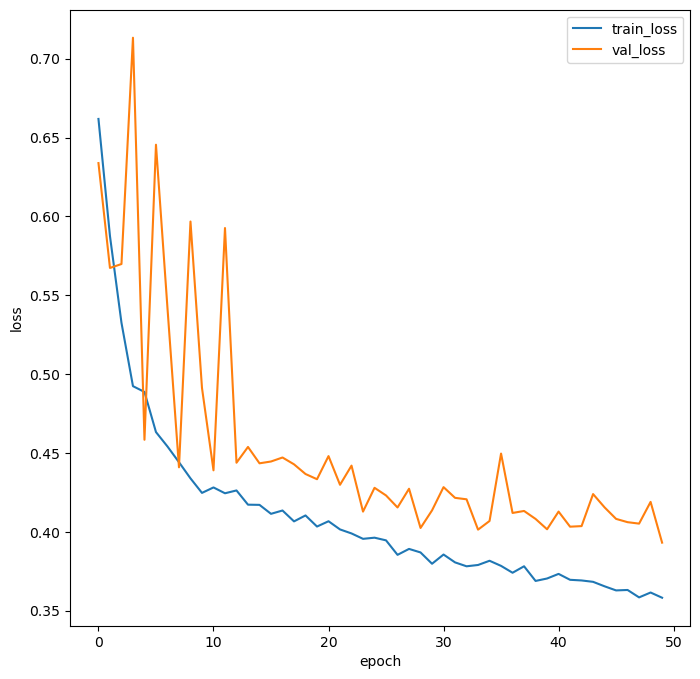

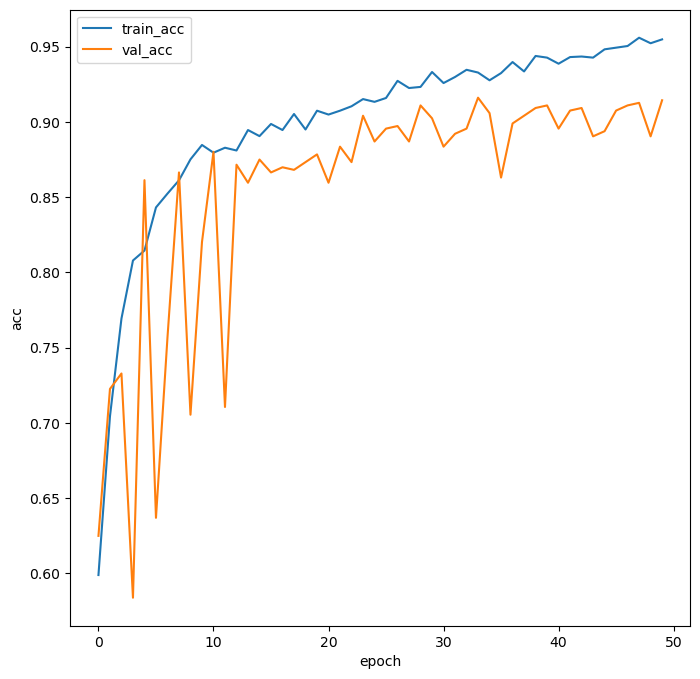

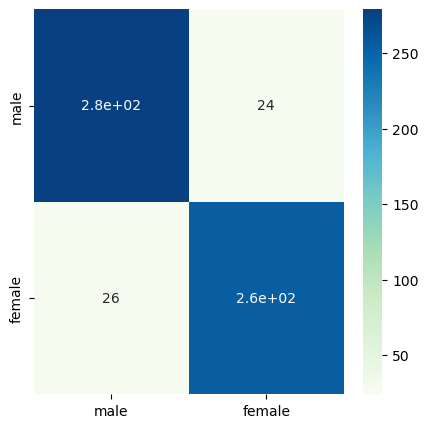

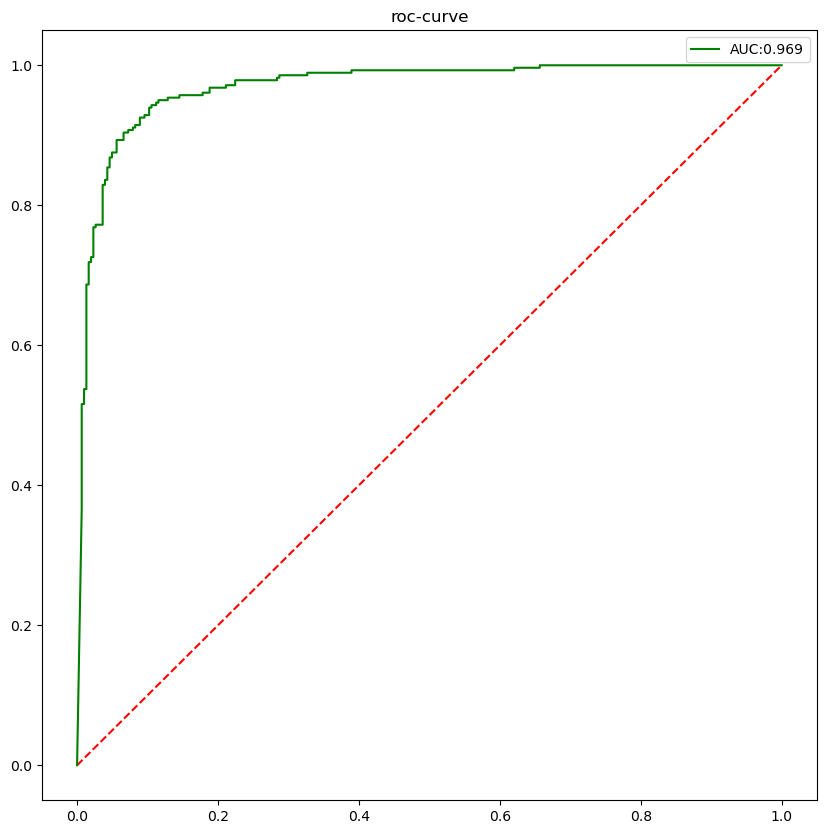

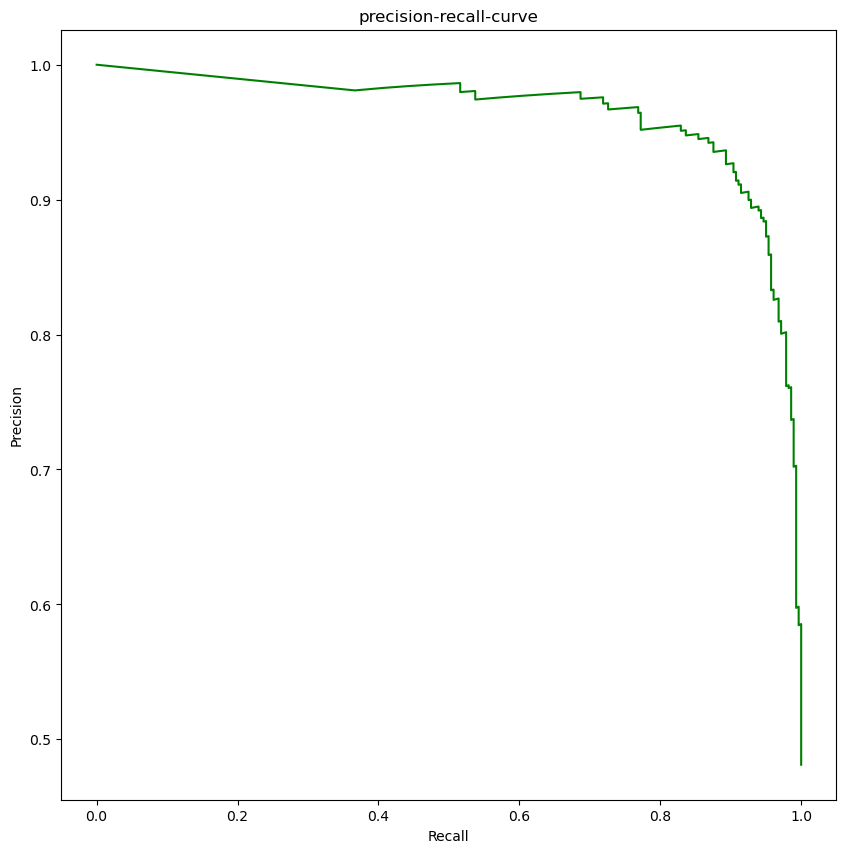

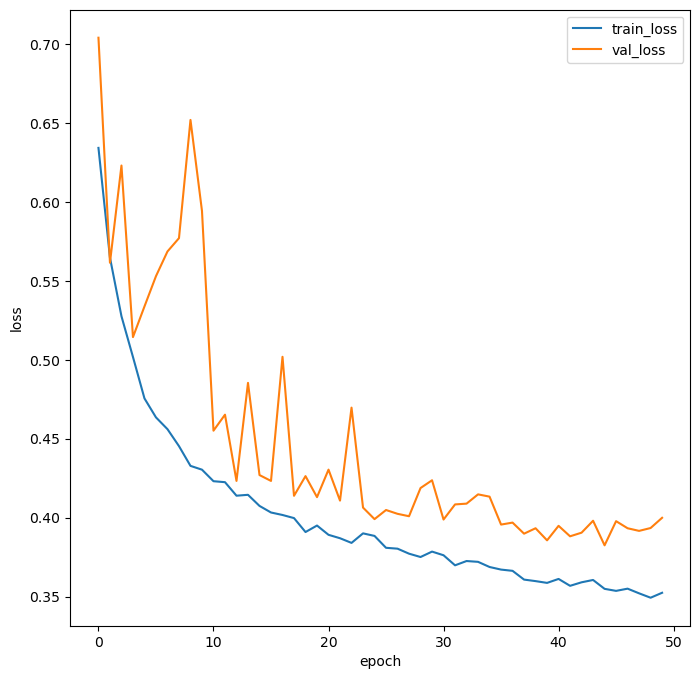

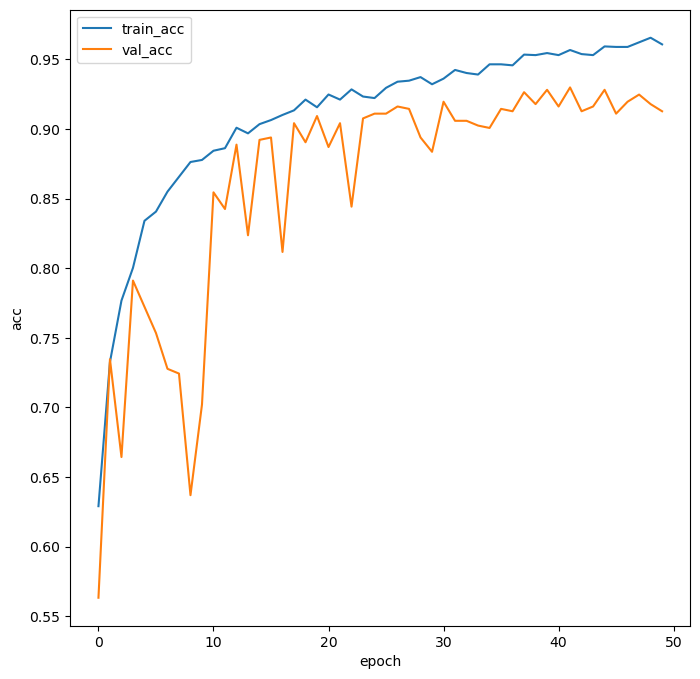

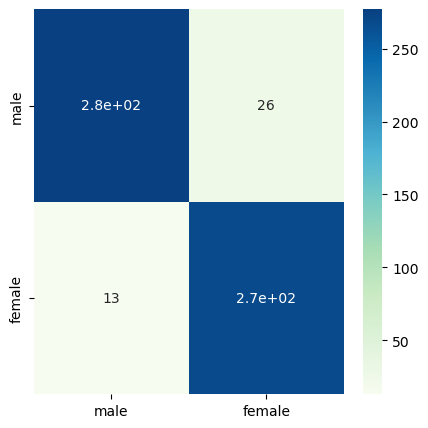

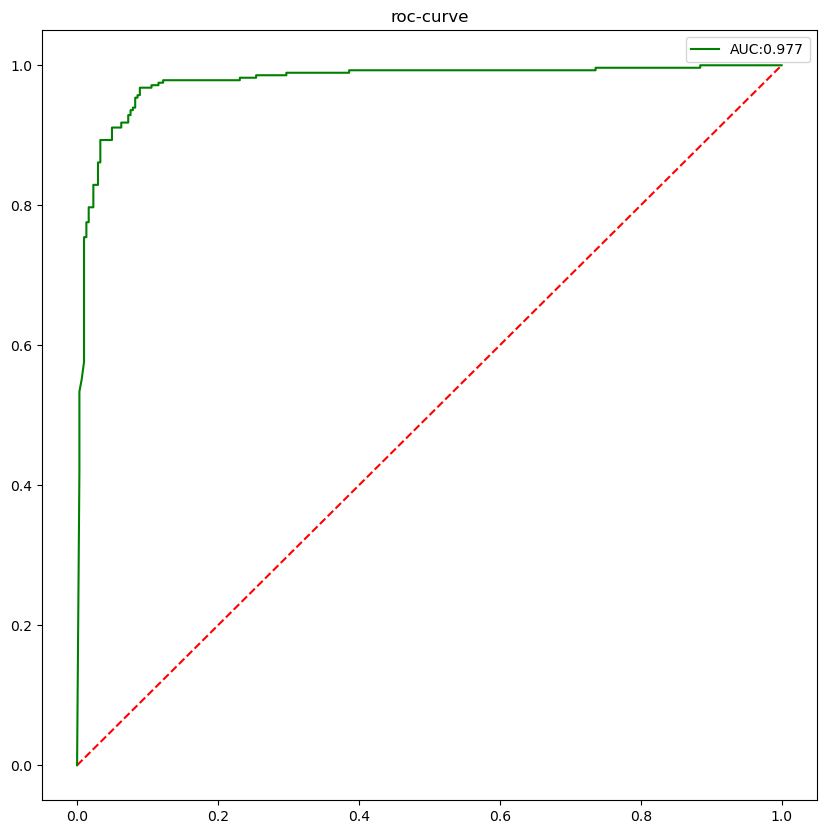

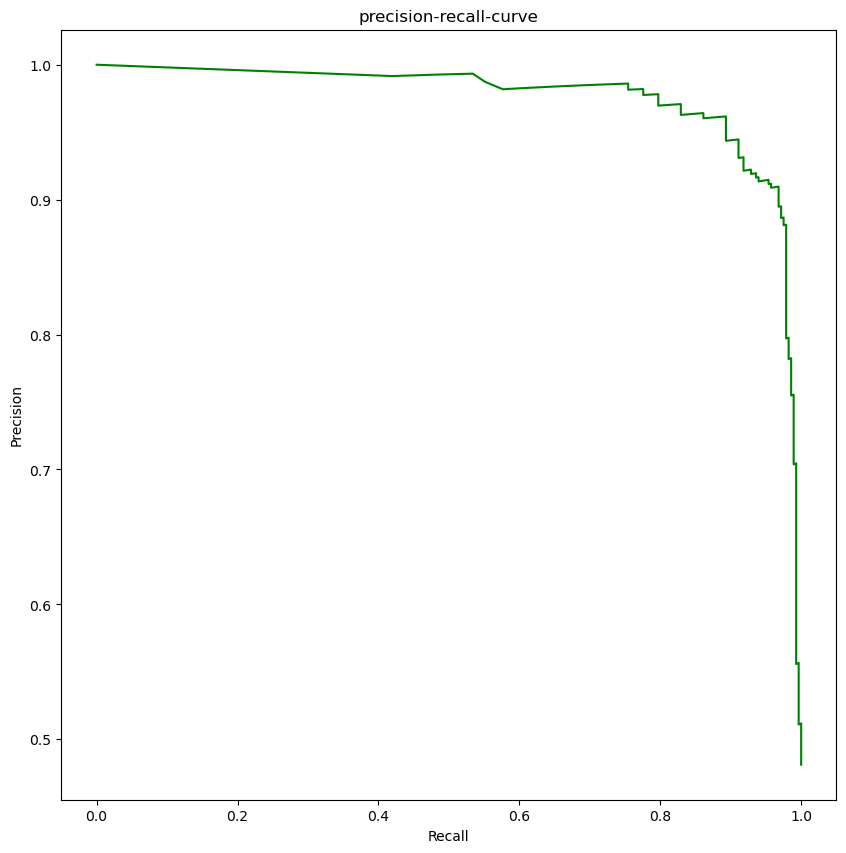

In [12]:
# Train the model1 and model2 respectively
train(model_name="model1")
get_test_result(model_path="models/model1_best.h5")
train(model_name="model2")
get_test_result(model_path="models/model2_best.h5")

In [13]:
# According to the weights of the model after training, use the majority voting method to ensemble the model.
def get_test_result_ensemble(model_paths):
    models = [load_model(model_path) for model_path in model_paths]
    test_loader = DataGenerator(root="datasets/test.txt", batch_size=32)
    labels_onehot, labels_prob = [], []
    
# --------------------------------------------------Ensemble model and Evaluation--------------------------------------------------
    for x, y in test_loader:
        ensemble_probs = np.zeros((len(x), 2))
        # Iterate over each model in the integration
        for model in models:
            prob = model.predict(x)
            # Add the forecast to the ensemble_probs array
            ensemble_probs += prob

        # Average the predictions of all models.
        ensemble_probs /= len(models)
        # Add integrated forecast and real label to the list for evaluation.
        labels_prob.append(ensemble_probs)
        labels_onehot.append(y)
        
    # Join the list to create an array for further evaluation
    labels_onehot = np.concatenate(labels_onehot, axis=0)
    labels_prob = np.concatenate(labels_prob, axis=0)
    labels_pred = np.argmax(labels_prob, axis=-1)
    labels_true = np.argmax(labels_onehot, axis=-1)

    accuracy = accuracy_score(labels_true, labels_pred)
    error = 1 - accuracy
    recall = recall_score(labels_true, labels_pred)
    precision = precision_score(labels_true, labels_pred)
    f1 = f1_score(labels_true, labels_pred)
    matrix = confusion_matrix(labels_true, labels_pred)
    TP, FP, FN, TN = matrix[0, 0], matrix[0, 1], matrix[1, 0], matrix[1, 1]
    TPR = TP / (TP + FN)
    TNR = TN / (FP + TN)

    print(f"accuracy:{accuracy}")
    print(f"error:{error}")
    print(f"recall:{recall}")
    print(f"precision:{precision}")
    print(f"sensitivity:{TPR}")
    print(f"specificity:{TNR}")
    print(f"f1_score:{f1}")

    matrix = pd.DataFrame(matrix, columns=["male", "female"], index=["male", "female"])
    plt.figure(figsize=(5, 5))
    seaborn.heatmap(matrix, cmap="GnBu", annot=True)
    plt.savefig(f"plots/ensemble_confusion_matrix.jpg")

    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(labels_true, labels_prob[:, -1])
    plt.plot([0, 1], [0, 1], "r--")
    plt.plot(fpr, tpr, c="green", label=f"AUC:{auc(fpr, tpr):.3f}")
    plt.legend()
    plt.title("roc-curve")
    plt.savefig(f"plots/ensemble_roc_curve.jpg")

    plt.figure(figsize=(8, 8))
    precision, recall, thresholds = precision_recall_curve(labels_true, labels_prob[:, -1])
    plt.plot(recall, precision,c="green")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("precision-recall-curve")
    plt.savefig(f"plots/ensemble_precision_recall_curve.jpg")

1/1 [==============================] - 0s 301ms/step
accuracy:0.928082191780822
error:0.07191780821917804
recall:0.9359430604982206
precision:0.9163763066202091
sensitivity:0.9393939393939394
specificity:0.9163763066202091
f1_score:0.926056338028169


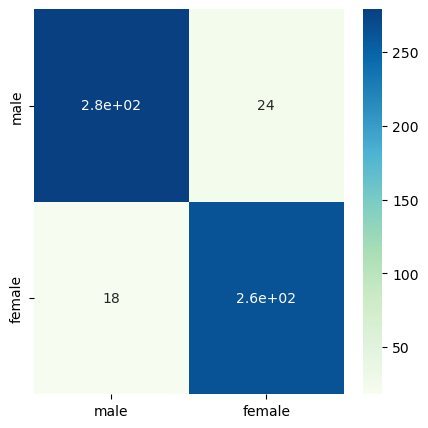

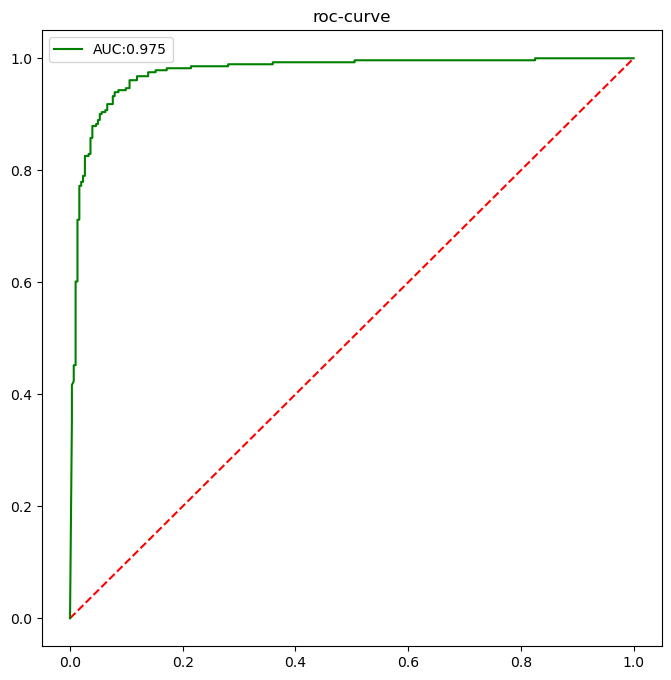

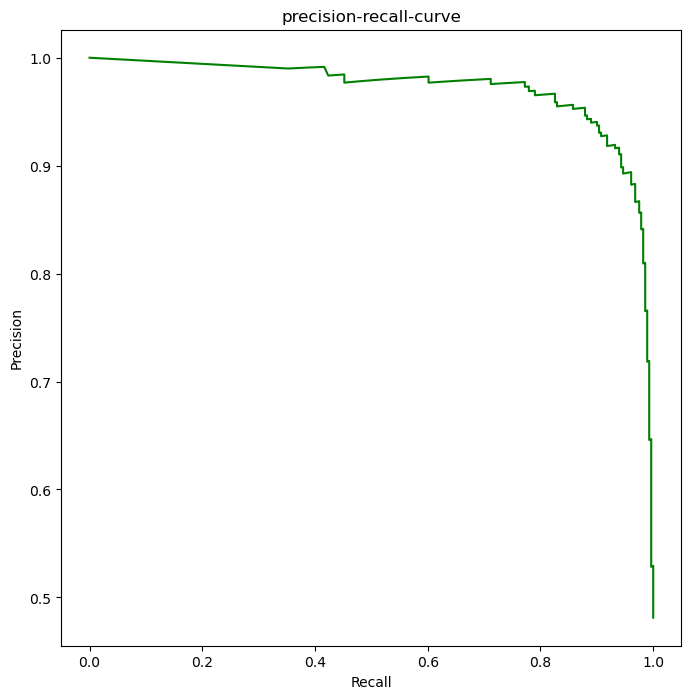

In [14]:
model_paths = ["models/model1_best.h5","models/model2_best.h5"]
get_test_result_ensemble(model_paths)